### Data Visualization - Ideal vs Encountered

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from IPython.display import HTML


#### Load Data

In [2]:
#windbag
bag_raw=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/test_animation_bag02_run02/anim_time.hdf')
we=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/test_animation_bag02_run02/ewdatabag02.hdf')
ns=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/test_animation_bag02_run02/nsdatabag02.hdf')

#odorbag
odor= pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Interpolated_0.h5')
time= odor.master_time-odor.master_time[0]
odor.insert(1,'sync_time',time) 

#### Converting lat lon information to meters

In [3]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

In [4]:
#source location to meters
source = (40.79376709443614, -119.15757512132207)
u =  utm.from_latlon(40.79376709443614, -119.15757512132207)

In [5]:
#adding sync_time from zero, optional

newtime= bag_raw.sync_time-bag_raw.sync_time.iloc[0]
bag_raw.insert(1,'ntime',newtime) 

newtime=newtime.reset_index()
# newtime = newtime.drop(columns=['index'])

we.insert(0,'sync_time',newtime.sync_time)
ns.insert(0,'sync_time',newtime.sync_time)

#### Selecting a smaller slot of data

In [6]:
query = 'sync_time >= 150 and sync_time <=180'
dfo = odor.query(query)
dfwe = we.query(query)
dfns = ns.query(query)

In [14]:
dfwe.iloc[1]

sync_time       150.100097
particle0      -156.450021
particle1      -156.245015
particle2      -156.043009
particle3      -155.843004
                   ...    
particle2992           NaN
particle2993           NaN
particle2994           NaN
particle2995           NaN
particle2996           NaN
Name: 1501, Length: 2998, dtype: float64

#### Animation 01 - Wind Only

In [4]:
fig = plt.figure()
ax = plt.axes(xlim=(-25,2.5), ylim=(-16,3))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()
line, = ax.plot([],[], 'o', lw=2)

def init():
    line.set_data([],[])
    return line,

def get_data_x(i):
    return we.loc[i]

def get_data_y(i):
    return ns.loc[i]

def update(i):
    x = get_data_x(i)
    y = get_data_y(i)
    line.set_data(x,y)
    return line,

an = animation.FuncAnimation(fig,update,frames = pd.Index.intersection(we.index,ns.index),
                              interval = 5, blit=False)
#an.save('../../../Research/Images/Video/fast_flow.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
# plt.show()

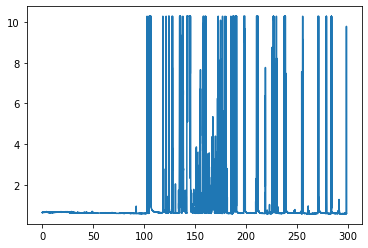

In [13]:
#odor data - view
plt.plot(odor.sync_time, odor.odor)

#### 2D scatter plot for entire 300 seconds for ideal vs actual odor counters

In [15]:
xfromsrc= geodf.x-u[0]
geodf.insert(10,'xsrc',xfromsrc) 

In [16]:
yfromsrc = geodf.y-u[1]
geodf.insert(11,'ysrc', yfromsrc)

(-16.0, 3.0)

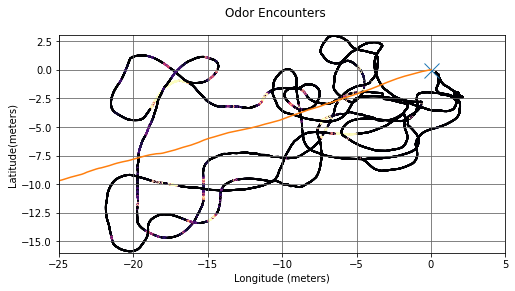

In [17]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor Encounters')

# Plot the data
ax.scatter(geodf.xsrc, geodf.ysrc, c=geodf.odor, cmap='magma', s= 0.8)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0)
ax.set_xlim(-25,5)
ax.set_ylim(-16,3)

#### 2D scatter plot for high odor concentration vs ideal wind particle

In [18]:
query = 'odor >= 7'
df_t=geodf.query(query)
df_t=df_t.reset_index()

(-16.0, 3.0)

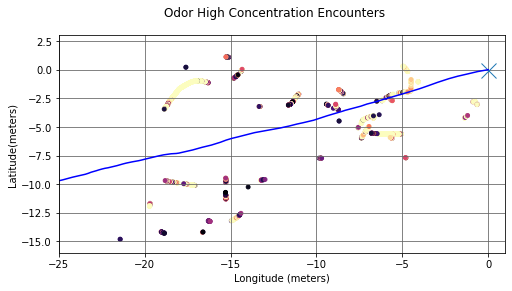

In [19]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor High Concentration Encounters')

# Plot the data
ax.scatter(df_t.xsrc, df_t.ysrc, c=df_t.odor, cmap='magma', s= 15)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, markersize=20, c='b')
ax.set_xlim(-25,1)
ax.set_ylim(-16,3)

#### ANIMATION 02 - Ideal vs Encountered Odor

In [20]:
query_ = 'sync_time >= 150 and sync_time <=180'
geodfsub = geodf.query(query_)

In [21]:
geodfsub = geodfsub.reset_index()

In [22]:
dfwe = dfwe.reset_index()
dfns = dfns.reset_index()

In [26]:
## Setting figure

fig = plt.figure()
ax = plt.axes(xlim=(-25,2.5), ylim=(-16,3))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()

wind, = ax.plot([],[], 'o', color ="b", lw = 2)
line, = ax.plot([],[], 'x', color = "r", lw = 2)


## Callbacks 

def init():
    line.set_data([],[])  
    wind.set_data([],[])
    return wind,

def get_data_we_(i):
    return dfwe.loc[i]

def get_data_ns_(i):
    return dfns.loc[i]


def get_data_x_(i):
    return geodfsub.xsrc[i]

def get_data_y_(i):
    return geodfsub.ysrc[i]

In [27]:
def update(i):
    wex = get_data_we_(i)
    nsy = get_data_ns_(i)
    wind.set_data(wex,nsy)
#     x = get_data_x_(i)
#     y = get_data_y_(i)
#     line.set_data(x,y)
    
    return wind,



In [29]:
# ani = animation.FuncAnimation(fig, update, init_func=init, frames = int(len(geodfsub.ysrc)/2), interval = 5, blit=False)
ani = animation.FuncAnimation(fig, update, init_func=init, frames = 500, interval = 5, blit=False)


#ani.save('../../../Research/Images/Video/test_ideal.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
#HTML(ani.to_html5_video())




#### Alternative animation method using multiple plots (extremely slow)

In [39]:
dir = '../../../Research/Images/recurringplots/'
for i in range(300):
    plt.figure(figsize=(5,5))
    plt.xlim(-25,2)
    plt.ylim(-16,3)
    plt.scatter(geodfsub.xsrc[i],geodfsub.ysrc[i], c=geodfsub.odor[i], cmap='magma', s=20)
    plt.plot(dfwe.loc[i],dfns.loc[i])
    
    plt.savefig(dir + "plot" + str(i) + ".png")
    plt.close()

In [36]:
#dfns = dfns.drop(columns=[ 'index1', 'sync_time'])
dfwe = dfwe.drop(columns=['index', 'sync_time'])

In [89]:
dfns.shape 

(301, 2997)

In [90]:
dfwe.shape

(301, 2997)

In [91]:
geodf.ysrc.shape

(59762,)

geodf